# Exercise 1.3

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [3]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
    ])

In [4]:
batch_size = 64
trainset = datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

* Make a CNN to train on the CIFAR10 dataset

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(7*7*64, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
            nn.Softmax(dim=1))

    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [7]:
model = Network()
model.to(device)

# First minibatch
data = next(iter(train_loader))[0].to(device)
# Used to determine first linear layer conf in fully connected
print('Shape of the output from the convolutional part', model.convolutional(data).shape)


Shape of the output from the convolutional part torch.Size([64, 64, 7, 7])


In [8]:
model_SDG = Network()
model_Adam = Network()
model_SDG.to(device)
model_Adam.to(device)
#Initialize the optimizer
optimizer_SDG = torch.optim.SGD(model_SDG.parameters(), lr=0.1)
optimizer_Adam = torch.optim.Adam(params=model_Adam.parameters(), lr=0.001)

In [38]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(output, target) #Use softmax and F.nll_loss(torch.log(output), target) else nn.LogSoftmax() and F.nll_loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [10]:
out_dict_Adam = train(model_Adam, optimizer_Adam)
out_dict_SDG = train(model_SDG, optimizer_SDG)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.365	 test: 1.204	 Accuracy train: 50.4%	 test: 56.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.000	 test: 0.837	 Accuracy train: 64.3%	 test: 70.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.841	 test: 0.896	 Accuracy train: 70.3%	 test: 69.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.729	 test: 0.643	 Accuracy train: 74.3%	 test: 77.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.647	 test: 0.595	 Accuracy train: 77.3%	 test: 79.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.569	 test: 0.531	 Accuracy train: 79.8%	 test: 81.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.500	 test: 0.362	 Accuracy train: 82.4%	 test: 87.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.438	 test: 0.364	 Accuracy train: 84.4%	 test: 87.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.384	 test: 0.332	 Accuracy train: 86.3%	 test: 88.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.331	 test: 0.318	 Accuracy train: 88.1%	 test: 88.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.468	 test: 1.282	 Accuracy train: 46.1%	 test: 52.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.096	 test: 2.276	 Accuracy train: 60.8%	 test: 39.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.888	 test: 1.197	 Accuracy train: 68.6%	 test: 58.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.746	 test: 0.930	 Accuracy train: 73.7%	 test: 68.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.631	 test: 0.752	 Accuracy train: 77.7%	 test: 73.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.538	 test: 0.546	 Accuracy train: 81.1%	 test: 80.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.445	 test: 0.724	 Accuracy train: 84.3%	 test: 75.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.365	 test: 1.077	 Accuracy train: 87.1%	 test: 67.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.293	 test: 0.270	 Accuracy train: 89.7%	 test: 90.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.232	 test: 0.217	 Accuracy train: 91.9%	 test: 92.4%


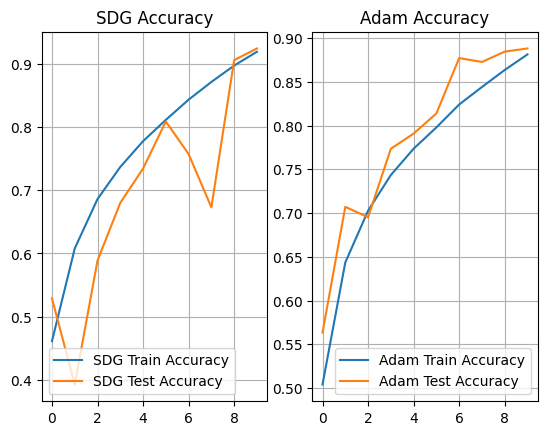

In [11]:
fig, ax = plt.subplots(1,2)
ax[0].plot(out_dict_SDG['train_acc'], label='SDG Train Accuracy')
ax[0].plot(out_dict_SDG['test_acc'], label='SDG Test Accuracy')
ax[0].set_title('SDG Accuracy')
ax[0].legend()
ax[0].grid()

ax[1].plot(out_dict_Adam['train_acc'], label='Adam Train Accuracy')
ax[1].plot(out_dict_Adam['test_acc'], label='Adam Test Accuracy')
ax[1].set_title('Adam Accuracy')
ax[1].legend()
ax[1].grid()


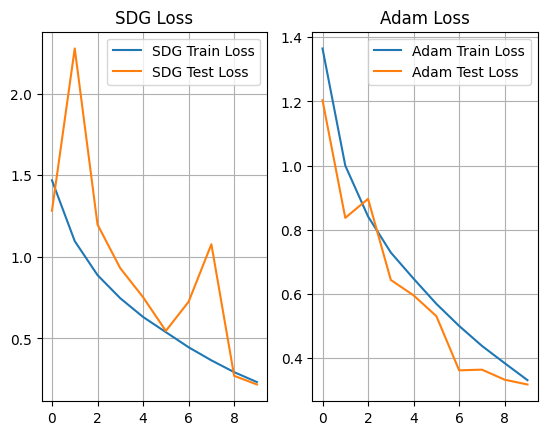

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].plot(out_dict_SDG['train_loss'], label='SDG Train Loss')
ax[0].plot(out_dict_SDG['test_loss'], label='SDG Test Loss')
ax[0].set_title('SDG Loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(out_dict_Adam['train_loss'], label='Adam Train Loss')
ax[1].plot(out_dict_Adam['test_loss'], label='Adam Test Loss')
ax[1].set_title('Adam Loss')
ax[1].legend()
ax[1].grid()

In [13]:
# Earlier part of exercise
# plt.plot(out_dict['train_acc'], label='Train error')
# plt.plot(out_dict['test_acc'], label='Test error')
# plt.legend()
# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')
# plt.show()

# plt.plot(out_dict['train_loss'], label='Train loss')
# plt.plot(out_dict['test_loss'], label='Test loss')
# plt.legend()
# plt.xlabel('Epoch number')
# plt.ylabel('Loss')
# plt.show()

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?
A decent accuracy of 75%. It underfits the data. I changed it to a larger network, larger receptive fields in first conv2d and more features. 

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
Yes, I guess so.
* Which optimizer works best for you?
It seems similarly by now. Adam ends on 78% which is a bit lower than SDG's 85%
* Plot the test and test errors for both SGD and Adam in one plot. Done!
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [39]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_features, n_features, 3, 1, 1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(n_features, n_features, 3, 1, 1)
        self.act2 = nn.ReLU()

    def forward(self, x):
        conv_part = self.conv2(self.act1(self.conv1(x)))
        out = self.act2(conv_part + x)
        return out

The following code is a sanity of your residual block network

In [40]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

Passed sanity check


We define a network that uses your `ResNetBlock`

In [41]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.LogSoftmax())
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [42]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

/Users/clarasofiechristiansen/anaconda3/envs/DL_CV_02516/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss train: 1.891	 test: 1.738	 Accuracy train: 32.1%	 test: 38.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.532	 test: 1.385	 Accuracy train: 44.7%	 test: 48.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.292	 test: 1.306	 Accuracy train: 53.7%	 test: 52.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.090	 test: 1.347	 Accuracy train: 61.2%	 test: 55.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.881	 test: 0.639	 Accuracy train: 68.5%	 test: 77.5%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.636	 test: 0.847	 Accuracy train: 77.4%	 test: 72.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.398	 test: 0.787	 Accuracy train: 86.1%	 test: 77.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.242	 test: 0.195	 Accuracy train: 91.8%	 test: 93.7%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.150	 test: 0.114	 Accuracy train: 94.9%	 test: 96.0%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.107	 test: 0.114	 Accuracy train: 96.4%	 test: 96.3%




Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.